# Proyek Analisis Data: Air Quality @Wanliu
- **Nama:** Rizqi Hasanuddin
- **Email:** rizqih6x@gmail.com
- **ID Dicoding:** rzqh00

# Menentukan Pertanyaan Bisnis
#### 1. Apa korelasi antara kadar PM2.5 dengan berbagai kondisi cuaca?
#### 2. Bagaimana variasi kadar PM2.5 pada setiap tahunnya?

#### NB: 
##### PM2.5 adalah partikel udara yang sangat kecil dengan ukuran <2.5 mikrometer, kadar PM2.5 yang cukup berbahaya sering kita hirup dalam kehidupan sehari-hari seperti polusi kendaraan, debu jalanan, asap rokok, dll. Dengan berbagai resiko penyakitnya, oleh karena itu penting untuk memantau kadar PM2.5 di lingkungan sekitar dan mengambil langkah-langkah untuk mengurangi paparannya
##### Maka dari itu saya memutuskan untuk mengambil studi kasus Air Quality dengan dataset yang berlokasikan di Wanliu China

# **Data Wrangling**

## **Gathering Data**

In [39]:
import pandas as pd  # manipulasi dan analisis data
import numpy as np   # operasi numerik dan array
import matplotlib.pyplot as plt  # visualisasi data 
import seaborn as sns  # visualisasi data lebih lanjut(advance)

# analisis statistik
import statsmodels.api as sm
from scipy.stats import f_oneway

# set style seaborn
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

file_path = 'data/PRSA_Data_Wanliu_20130301-20170228.csv'
df = pd.read_csv(file_path)

## **Assessing Data**

In [43]:
initial_assessment = df.head()
initial_columns = df.columns
initial_datatypes = df.dtypes

initial_assessment, initial_columns, initial_datatypes

(   No  year  month  day  hour  PM2.5  PM10  SO2   NO2     CO    O3  TEMP  \
 0   1  2013      3    1     0    8.0   8.0  6.0  28.0  400.0  52.0  -0.7   
 1   2  2013      3    1     1    9.0   9.0  6.0  28.0  400.0  50.0  -1.1   
 2   3  2013      3    1     2    3.0   6.0  NaN  19.0  400.0  55.0  -1.1   
 3   4  2013      3    1     3   11.0  30.0  8.0  14.0    NaN   NaN  -1.4   
 4   5  2013      3    1     4    3.0  13.0  9.0   NaN  300.0  54.0  -2.0   
 
      PRES  DEWP  RAIN   wd  WSPM station  
 0  1023.0 -18.8   0.0  NNW   4.4  Wanliu  
 1  1023.2 -18.2   0.0    N   4.7  Wanliu  
 2  1023.5 -18.2   0.0  NNW   5.6  Wanliu  
 3  1024.5 -19.4   0.0   NW   3.1  Wanliu  
 4  1025.2 -19.5   0.0    N   2.0  Wanliu  ,
 Index(['No', 'year', 'month', 'day', 'hour', 'PM2.5', 'PM10', 'SO2', 'NO2',
        'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM', 'station'],
       dtype='object'),
 No           int64
 year         int64
 month        int64
 day          int64
 hour       

## **Cleaning Data**

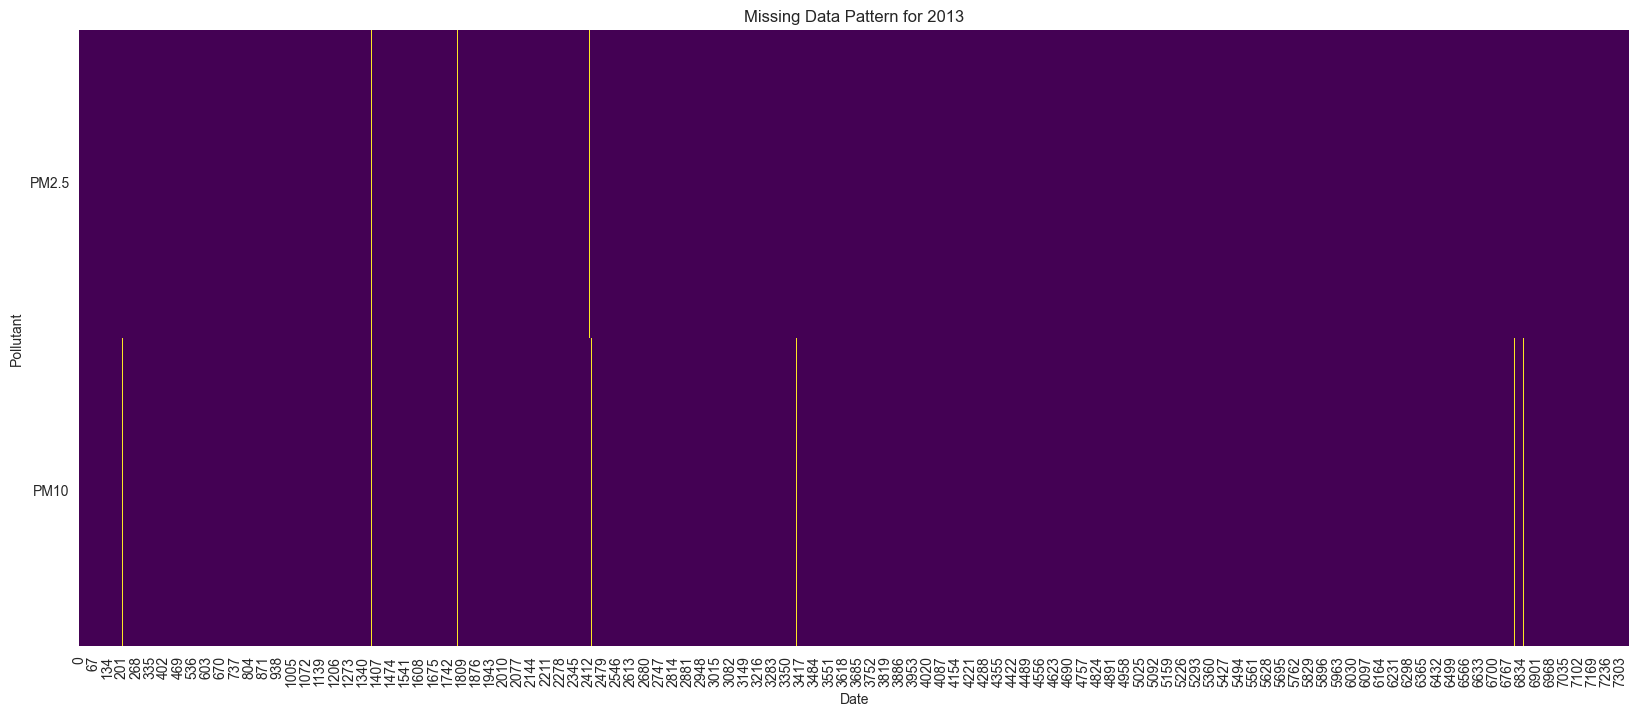

(No         0.000000
 year       0.000000
 month      0.000000
 day        0.000000
 hour       0.000000
 PM2.5      1.089436
 PM10       0.809948
 SO2        1.639859
 NO2        3.051563
 CO         5.167693
 O3         6.009012
 TEMP       0.057039
 PRES       0.057039
 DEWP       0.057039
 RAIN       0.057039
 wd         0.350787
 WSPM       0.039927
 station    0.000000
 dtype: float64,
 PM2.5          21
 PM10           20
 year     14783472
 dtype: int64)

In [51]:
missing_percentage = df.isnull().mean() * 100
cols_to_plot = ['PM2.5', 'PM10']
data_missing = df[cols_to_plot].isnull()
data_missing['year'] = df['year']
data_missing_2013 = data_missing[data_missing['year'] == 2013]
plt.figure(figsize=(20, 8))
sns.heatmap(data_missing_2013.drop('year', axis=1).T, cmap='viridis', cbar=False)
plt.title('Missing Data Pattern for 2013')
plt.xlabel('Date')
plt.ylabel('Pollutant')
plt.yticks(rotation=0) 
plt.show()

missing_percentage, data_missing_2013.sum()

### **Missing Data**
- Terdapat persentase missing data polutan(PM2.5 dan PM10) yang relatif kecil, dengan PM2.5 sekitar 1,08% dan PM10 sekitar 0,80% missing data. Begitu juga pada data yang lain menunjukkan persentase missing data yang kecil, maka dari itu dapat disimpulkan bahwa dataset berikut sudah relatif lengkap.
- Heatmap tahun pertama pada dataset ini(2013) mengindikasikan data missing untuk PM2.5 dan PM10 tidak terdapat pola yang jelas, yang menunjukkan bahwa hilangnya data tersebut mungkin bersifat tidak sistematis. Tidak ada missing data dengan waktu yang cukup panjang, maka dari itu merupakan tanda baik untuk analisis time series.

In [53]:
# using forward fill untuk mengatasi missing values
data_imputed = df.ffill()

# count jumlah duplikat
duplicates = data_imputed.duplicated().sum()

# kolom konstan
constant_columns = data_imputed.columns[data_imputed.nunique() <= 1]

# get tipe data
data_types = data_imputed.dtypes

# Menampilkan hasil
duplicates, constant_columns, data_types


(np.int64(0),
 Index(['station'], dtype='object'),
 No           int64
 year         int64
 month        int64
 day          int64
 hour         int64
 PM2.5      float64
 PM10       float64
 SO2        float64
 NO2        float64
 CO         float64
 O3         float64
 TEMP       float64
 PRES       float64
 DEWP       float64
 RAIN       float64
 wd          object
 WSPM       float64
 station     object
 dtype: object)

In [54]:
summary_statistics = data_imputed.describe()
summary_statistics

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM
count,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.00000
mean,17532.500000,2014.662560,6.522930,15.729637,11.500000,83.516054,110.658234,18.417596,65.970555,1331.700091,46.920645,13.426323,1011.102728,3.263752,0.068224,1.50130
std,10122.249256,1.177213,3.448752,8.800218,6.922285,82.177505,93.613123,22.743577,38.242816,1267.955273,54.452884,11.348467,10.356530,13.679802,0.896471,1.10461
min,1.000000,2013.000000,1.000000,1.000000,0.000000,2.000000,2.000000,0.285600,1.642400,100.000000,0.214200,-15.800000,985.900000,-34.900000,0.000000,0.00000
25%,8766.750000,2014.000000,4.000000,8.000000,5.750000,23.000000,40.000000,4.000000,36.543400,600.000000,3.000000,3.100000,1002.500000,-8.100000,0.000000,0.80000
50%,17532.500000,2015.000000,7.000000,16.000000,11.500000,59.000000,88.000000,10.000000,61.000000,900.000000,29.000000,14.300000,1010.800000,4.000000,0.000000,1.20000
75%,26298.250000,2016.000000,10.000000,23.000000,17.250000,116.000000,153.000000,23.000000,90.000000,1600.000000,70.000000,22.900000,1019.400000,15.800000,0.000000,2.00000
max,35064.000000,2017.000000,12.000000,31.000000,23.000000,957.000000,951.000000,282.000000,264.000000,10000.000000,364.000000,40.500000,1040.300000,28.500000,72.500000,11.20000


### **Cleaned Data**
- Forward fill imputation untuk missing values.
- Menjadikan kolom 'station' as constant.
- Pemeriksaan dan tidak ditemukan anomali data berupa data duplikat

# **Exploratory Data Analysis (EDA)**

#### - Melakukan summary stats.
#### - Analisis tren time-series tingkatan PM2.5
#### - Uji one-way ANOVA untuk mengetahui perbedaan PM2.5 dalam kurun waktu tahunan
#### - "Investigasi" tren musiman dan korelasinya dengan kondisi cuaca

# **Visualization & Explanatory Analysis**

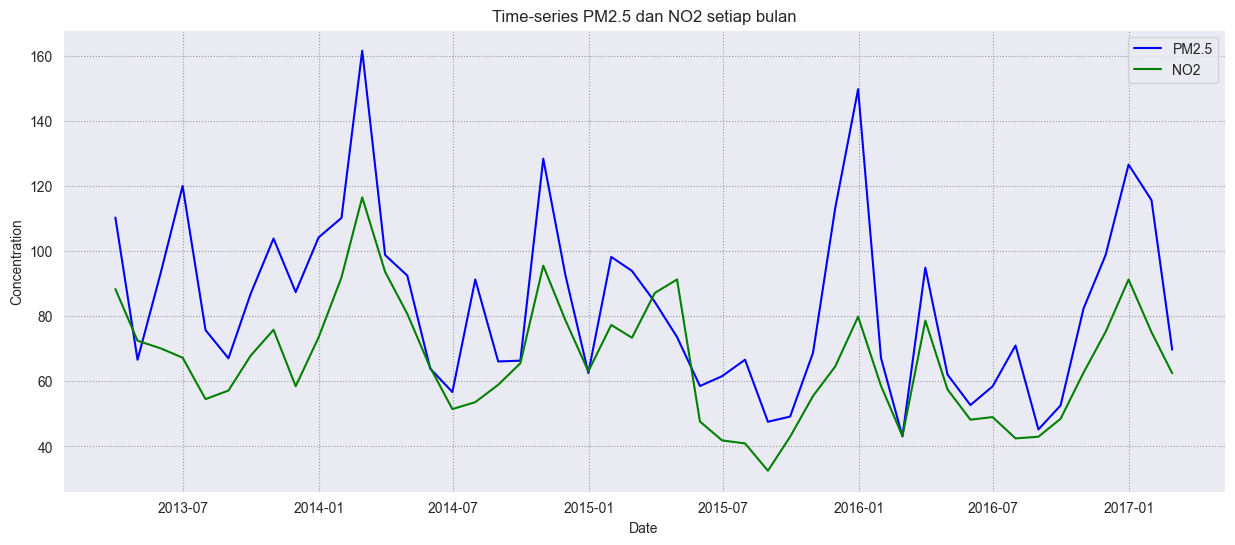

In [59]:
data_imputed['date'] = pd.to_datetime(data_imputed[['year', 'month', 'day', 'hour']])
data_time_series = data_imputed[['date', 'PM2.5', 'NO2']].set_index('date').resample('ME').mean()

plt.figure(figsize=(15, 6))
plt.plot(data_time_series.index, data_time_series['PM2.5'], label='PM2.5', color='blue')
plt.plot(data_time_series.index, data_time_series['NO2'], label='NO2', color='green')
plt.title('Time-series PM2.5 dan NO2 setiap bulan')
plt.xlabel('Date')
plt.ylabel('Concentration')
plt.legend()
plt.show()


In [56]:
correlation_matrix = data_imputed[['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']].corr()
correlation_matrix

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM
PM2.5,1.000000,0.878975,0.499380,0.665249,0.737815,-0.163904,-0.133221,0.005498,0.102573,-0.012587,-0.244767
PM10,0.878975,1.000000,0.473358,0.670958,0.656472,-0.154037,-0.120327,-0.019725,0.053862,-0.029149,-0.165799
SO2,0.499380,0.473358,1.000000,0.522820,0.552626,-0.183486,-0.329508,0.229412,-0.280866,-0.038326,-0.038752
NO2,0.665249,0.670958,0.522820,1.000000,0.631990,-0.473654,-0.295322,0.128006,-0.061057,-0.057105,-0.355911
CO,0.737815,0.656472,0.552626,0.631990,1.000000,-0.318183,-0.404937,0.233887,-0.157910,-0.020609,-0.252127
O3,-0.163904,-0.154037,-0.183486,-0.473654,-0.318183,1.000000,0.604177,-0.447923,0.315927,0.024307,0.304518
TEMP,-0.133221,-0.120327,-0.329508,-0.295322,-0.404937,0.604177,1.000000,-0.827706,0.822985,0.036738,0.006754
PRES,0.005498,-0.019725,0.229412,0.128006,0.233887,-0.447923,-0.827706,1.000000,-0.779135,-0.060909,0.103846
DEWP,0.102573,0.053862,-0.280866,-0.061057,-0.157910,0.315927,0.822985,-0.779135,1.000000,0.081783,-0.347490
RAIN,-0.012587,-0.029149,-0.038326,-0.057105,-0.020609,0.024307,0.036738,-0.060909,0.081783,1.000000,0.009850


# Summary stats
Hasil dari variabel summary_statistics memberikan gambaran umum tentang central tendency dan penyebaran setiap variabel data. Misalnya PM2.5 memiliki mean sebesar 83.51 dengan standard deviation 82.17 yang menunjukkan variabilitas signifikan dalam polutan ini

# Analisis Time-series
Time-series PM2.5 dan NO2 setiap bulan: Line chart pada chart tersebut menjunjukkan rata-rata PM2.5 dan NO2 dari waktu ke waktu setiap bulannya. Visualisasi ini membantu identifikasi tren musiman atau perubahan kualitas udara dari bulan ke bulan.

# Analisis Korelasi
- Korelasi polusi: Matriks korelasi menunjukkan korelasi antara berbagai polusi dan data meteorologi. Misalnya terdapat korelasi positif yang kuat antara PM2.5 dan NO2, yang menunjukkan terdapat kemungkinan kuat atas interaksi antara polutan tersebut.
- Cuaca dan Polusi: Terdapat korelasi yang menarik antara kondisi cuaca dan polusi, seperti korelasi negatif antara O3 dan suhu serta tekanan atmosfier

Hasil Uji ANOVA: F_onewayResult(statistic=np.float64(90.31688298213537), pvalue=np.float64(1.6141840128870638e-76))
Tren Musiman: month
1      97.783804
2      91.600295
3      97.069187
4      73.662847
5      67.020766
6      74.155903
7      76.139785
8      56.463441
9      63.711875
10     95.801747
11     97.968646
12    110.739079
Name: PM2.5, dtype: float64
Korelasi dengan Kondisi Cuaca: TEMP    -0.133353
PRES     0.005119
DEWP     0.102390
RAIN    -0.012699
PM2.5    1.000000
Name: PM2.5, dtype: float64


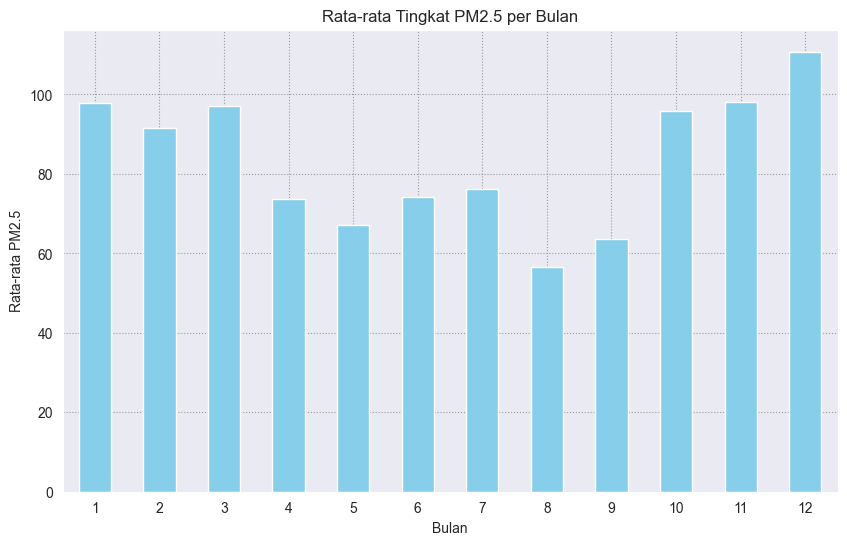

In [63]:
data_imputed = df.ffill()

# Mengelompokkan data berdasarkan tahun dan memilih kolom 'PM2.5'
groups = data_imputed.groupby('year')['PM2.5']

# Membuat list dari nilai rata-rata PM2.5 untuk setiap tahun
anova_test_data = [group[1] for group in groups]

# Melakukan uji ANOVA satu arah untuk membandingkan rata-rata PM2.5 antar tahun
anova_test_result = f_oneway(*anova_test_data)

# Mengelompokkan data berdasarkan bulan dan menghitung rata-rata PM2.5 untuk setiap bulan
seasonal_trends = data_imputed.groupby('month')['PM2.5'].mean()

# Menghitung korelasi antara PM2.5 dengan variabel cuaca (suhu, tekanan, titik embun, curah hujan)
weather_correlations = df[['TEMP', 'PRES', 'DEWP', 'RAIN', 'PM2.5']].corr()['PM2.5']

# Mencetak hasil uji ANOVA, tren musiman, dan korelasi cuaca
print("Hasil Uji ANOVA:", anova_test_result)
print("Tren Musiman:", seasonal_trends)
print("Korelasi dengan Kondisi Cuaca:", weather_correlations)

# Membuat plot batang untuk visualisasi tren musiman PM2.5
plt.figure(figsize=(10, 6))
seasonal_trends.plot(kind='bar', color='skyblue')
plt.title('Rata-rata Tingkat PM2.5 per Bulan')
plt.xlabel('Bulan')
plt.ylabel('Rata-rata PM2.5')
plt.xticks(ticks=range(0, 12), labels=[str(m) for m in range(1, 13)], rotation=0)
plt.show()

# Hypothesis Testing (ANOVA)

Hasil test ANOVA: One-way ANOVA test menunjukkan perbedaan yang signifikan secara statistik pada PM2.5 di berbagai tahun yang menunjukkan bahwa PM2.5 rata-rata tidak sama yang mendukung hipotesis alternatif.

# Tren Musiman
Kadar PM2.5 per Bulan: Bar chart Rata-rata Tingkat PM2.5 per Bulan menunjukkan bahwa terdapat lonjakan yang tinggi pada bulan-bulan musim dingin atau pra dan pasca tahun baru masehi dan terdapat kadar yang lebih rendah selama musim panas setelah bulan Juli hingga September

# Korelasi dengan Kondisi Cuaca
Hasil Korelasi: Korelasi antara PM2.5 dan kondisi cuaca menunjukkan:
- Korelasi negatif dengan suhu (TEMP), yang menunjukkan kadar PM2.5 yang lebih tinggi selama periode yang lebih dingin.
- Korelasi positif sedikit dengan titik embun (DEWP), yang menunjukkan kadar PM2.5 yang lebih tinggi mungkin berhubungan dengan kelembaban yang lebih tinggi.
- Tidak ada korelasi kuat dengan tekanan atmosfer (PRES) atau curah hujan (RAIN).

# **Kesimpulan**
### Pertanyaan 1
#### - Ditemukan variasi musiman pada tingkat kadar PM2.5 dengan tingkatan yang lebih tinggi pada bulan yang lebih dingin, yang menunjukkan pengaruh dari pemanasan global dan kondisi atmosfer.

### Pertanyaan 2
#### - Berdasarkan korelasi negatif antara tingkatan PM2.5 dengan tingkatan suhu, menunjukkan tingkat polusi yang lebih tinggi pada cuaca yang lebih dingin. Lalu ditemukan pula korelasi minimal dengan curah hujan dan kondisi atmosfer.